In [85]:
!conda create -n sarsa python=3.9 -y
!conda activate sarsa
!pip install "gymnasium[atari]" numpy matplotlib
!pip install autorom[accept-rom-license]  # Downloading Gym env data files
!AutoROM --accept-license  # Accepting the license for data files
!pip install ipykernel  # Install Jupyter kernel manager
!ipython kernel install --user --name=sarsa  # Add the new Conda env to Jupyter

/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed kernelspec sarsa in /root/.local/share/jupyter/kernels/sarsa


In [86]:
# import numpy as np
# import pandas as pd
# import gymnasium as gym
# env = gym.make('Taxi-v3', render_mode='rgb_array')

In [87]:
# import matplotlib.pyplot as plt
# initial_state, _ = env.reset()
# # Render the initial state
# img = env.render()
# # Create a figure and display the environment
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(img)
# # Remove axis ticks
# ax.set_xticks([])
# ax.set_yticks([]);

# SARSA Interaction loop

In [88]:
# # The number of states and actions
# n_states = env.observation_space.n
# n_actions = env.action_space.n
# print(n_states)
# print(n_actions)

In [89]:
# n_episodes = 5000

In [90]:
# for episodes in range(n_episodes):
#     state, _ = env.reset()
#     done = False
#     total_reward = 0
#     steps = 0
#     while not done:
#         action = env.action_space.sample() #random action initialization
#         next_state, reward, terminated, truncated, _ = env.step(action) #take action and observe the result        done = terminated or truncated
#         done = terminated or truncated
#         total_reward += reward
#         steps += 1
#         state = next_state
#     if episodes % 100 == 0:
#         print(f"Episode: {episodes+1}, Total Reward: {total_reward}, Steps: {steps}")

# animating the sarsa loop

In [91]:
# env = gym.make('Taxi-v3', render_mode='rgb_array')
# n_episodes = 2
# frames = []
# for episodes in range(n_episodes):
#     state, _ = env.reset()
#     img = env.render()
#     frames.append(img)
#     done = False
#     total_reward = 0
#     steps = 0
#     while not done:
#         action = env.action_space.sample()
#         next_state, reward, terminated, truncated, _ = env.step(action)
#         done = terminated or truncated
#         img = env.render()
#         frames.append(img)
#         total_reward += reward
#         steps += 1
#         state = next_state
#     if episodes % 2== 0:
#         print(f"Episode: {episodes+1}, Total Reward: {total_reward}, Steps: {steps}")

# AFter taking images of states and storing them in frames list, lets now turn them to GIF using moviepy library

In [92]:
!pip install moviepy

In [93]:
# from moviepy.editor import ImageSequenceClip
# def create_gif(frames: list, filename, fps = 5):
#     """
#     creates the GIF animation from a list of numpy arrays (frames)
#     args:
#         frames: list of numpy arrays
#         filename: name of the GIF file
#         fps: frames per second
#     """
#     clip = ImageSequenceClip(frames, fps=fps)
#     clip.write_gif(filename, fps=fps)

# #test
# create_gif(frames, 'sarsa.gif', fps=10)

# Implementing the SARSA with an epsilon greedy strategy for taking action rather than taking only a random action(exploration) like before. Now the agent will explore with a probability of `1-epsilon` and take actions based on best learned Q-values in the Q-table (exploitation based on current knowledge) with probability `epsilon`

## 1. Setting the Gymnasium environment

In [94]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip

In [95]:
def create_environment(env_name = "Taxi-v3", render_mode = "rgb_array"):
    env = gym.make(env_name, render_mode=render_mode)
    return env

## 2. Initializing a Q-table

In [96]:
# initialize a Q-table
def initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q_table = np.zeros((n_states, n_actions))
    return Q_table

# 3. Epsilon-greedy policy for taking action

In [97]:
def epsilon_greedy(env, Q_table, state, epsilon=0.1):
    if np.random.random() < epsilon:
        # Take a random action ie explore
        return env.action_space.sample()
    else:
      # Take action with highest Q-value ie exploitation
      return np.argmax(Q_table[state])

# 4. SARSA training

In [98]:
def sarsa_update(Q_table, state, action, reward, next_state, next_action, alpha, gamma):
   Q_table[state, action] += alpha * (
       reward + gamma * Q_table[next_state, next_action] - Q_table[state, action]
   )

In [113]:
# SARSA training
def train_sarsa(env, n_episodes = 20000, alpha= 0.1, gamma=0.99, epsilon=0.1):

    Q_table = initialize_q_table(env)
    episode_rewards = []
    episode_lengths = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(env, Q_table, state, epsilon)
        done = False
        total_reward = 0
        steps = 0
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy(env, Q_table, next_state, epsilon)
            sarsa_update(Q_table, state, action, reward, next_state, next_action, alpha, gamma)
            state = next_state
            action = next_action
            total_reward += reward
            steps += 1
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
    return Q_table, episode_rewards, episode_lengths

In [114]:
# Plotting the learning curve
def plot_learning_curve(episode_rewards, episode_lengths):
   plt.figure(figsize=(12, 5))
   plt.subplot(1, 2, 1)
   plt.plot(episode_rewards)
   plt.title("Episode Rewards")
   plt.xlabel("Episode")
   plt.ylabel("Total Reward")
   plt.subplot(1, 2, 2)
   plt.plot(episode_lengths)
   plt.title("Episode Lengths")
   plt.xlabel("Episode")
   plt.ylabel("Number of Steps")
   plt.tight_layout()
   plt.show()

In [115]:
# Creating the gif
def create_gif(frames, filename, fps=5):
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_gif(filename, fps=fps)

In [116]:
# One episode run
def run_episode(env, Q_table):
   state, _ = env.reset()
   done = False
   total_reward = 0
   frames = [env.render()]
   while not done:
       action = epsilon_greedy(env, Q_table, state, 0.1)
       next_state, reward, terminated, truncated, _ = env.step(action)
       done = terminated or truncated
       frames.append(env.render())
       total_reward += reward
       state = next_state
   return frames, total_reward

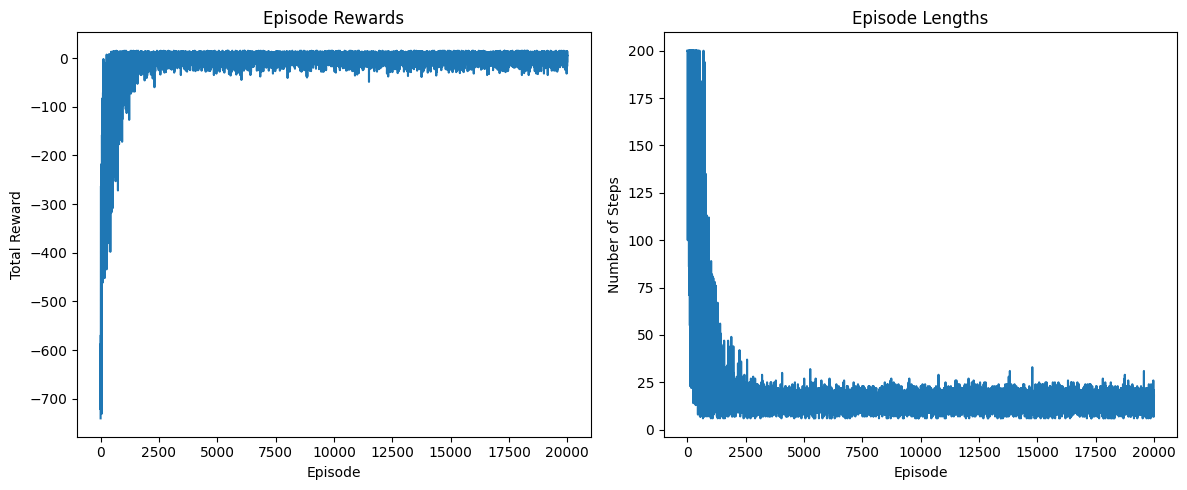

MoviePy - Building file /content/sarsa images/sarsa_final_animation.gif with imageio.


In [117]:
# Execute
if __name__ == "__main__":
    env = create_environment()

    Q_table, episode_rewards, episode_lengths = train_sarsa(env,n_episodes=20000)
    plot_learning_curve(episode_rewards, episode_lengths)

    frames, total_reward = run_episode(env, Q_table)
    create_gif(frames, "/content/sarsa images/sarsa_final_animation.gif", fps=1)

# Analysis of the rewards and lengths per episode

Initially when the agent is exploring and learning the environment the rewards are low.
Over time the rewards start to increase as the agent improve its policy and stabilize as the policy become better

At the beginning in graph B, the episodes are longer (large number of steps) as the agent less optimized options, and as learning progresses the episode length starts to decrease until it stabilizes showing efficient learning.